In [1]:
from torch.utils.data import Dataset
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from sklearn import decomposition
import torch.nn.functional as F
import seaborn as sns
from random import randint
from augment_functions import (
    random_mask,
    resize_encoder,
    augment_sample,
    augment_sample_random_mask,
    resize_to_orig,
)
from torchmetrics.image import (
    StructuralSimilarityIndexMeasure,
    PeakSignalNoiseRatio,
)

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
class WeatherBenchDataset(Dataset):
    def __init__(self, data, mask_prob=0.7):
        self.data = data
        self.mask_prob = mask_prob

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        x_orig = self.data[idx]
        x = resize_encoder(x_orig)
        masked_x = random_mask(x, mask_prob=self.mask_prob)
        y = idx
        return x_orig, x, masked_x, y

In [4]:
model = torch.load(
    "simclr_decoder_freeze.pth", weights_only=False, map_location=DEVICE
)
model.eval()

BATCH_SIZE = 100
data = torch.load("/vol/bitbucket/nb324/ERA5_64x32_daily_850.pt")
n_samples = data.shape[0]
n_train = int(n_samples * 0.6)
n_valid = int(n_samples * 0.2)
train_data = data[:n_train]
valid_data = data[n_train : n_train + n_valid]
test_data = data[n_train + n_valid :]

mean = train_data.mean(dim=(0, 2, 3), keepdim=True)
std = train_data.std(dim=(0, 2, 3), keepdim=True)

test_data = (test_data - mean) / std
test_dataset = WeatherBenchDataset(data=test_data, mask_prob=0.7)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [5]:
# Grab a batch
batch = list(testloader)[0]

batch = next(iter(testloader))

x_orig = batch[0][0].unsqueeze(0).to(DEVICE)
x = batch[1][0].unsqueeze(0).to(DEVICE)
masked_x = batch[2][0].unsqueeze(0).to(DEVICE)
y = batch[3].to(DEVICE)

print(x.shape)

torch.Size([1, 5, 144, 72])


In [6]:
with torch.no_grad():
    _, recon_x = model(x)
    _, recon_masked_x = model(masked_x)

In [11]:
mse_loss = torch.nn.MSELoss()
ssim_loss = StructuralSimilarityIndexMeasure(data_range=None)
psnr_loss = PeakSignalNoiseRatio(data_range=None)

mse = mse_loss(recon_masked_x, x_orig)
ssim = ssim_loss(recon_masked_x, x_orig)
psnr = psnr_loss(recon_masked_x, x_orig)

print(mse_loss(recon_x, x_orig))

print(f"Masked MSE Loss: {mse:.4f}")
print(f"Masked SSIM Loss: {ssim:.4f}")
print(f"Masked PSNR Loss: {psnr:.4f}")


ssim_loss = StructuralSimilarityIndexMeasure(data_range=1.0)
psnr_loss = PeakSignalNoiseRatio(data_range=1.0)
recon_masked_x_ = recon_masked_x * std + mean
x_orig_ = x_orig * std + mean

x_min = train_data.amin(dim=(0, 2, 3), keepdim=True)
x_max = train_data.amax(dim=(0, 2, 3), keepdim=True)

recon_masked_x_ = (recon_masked_x_ - x_min) / (x_max - x_min + 1e-8)
x_orig_ = (x_orig_ - x_min) / (x_max - x_min + 1e-8)

ssim = ssim_loss(recon_masked_x_, x_orig_)
psnr = psnr_loss(recon_masked_x_, x_orig_)

print(f"Masked Normalised SSIM Loss: {ssim:.4f}")
print(f"Masked Normalised PSNR Loss: {psnr:.4f}")

tensor(0.2712)
Masked MSE Loss: 0.0883
Masked SSIM Loss: 0.8130
Masked PSNR Loss: 29.2904
Masked Normalised SSIM Loss: 0.8724
Masked Normalised PSNR Loss: 29.0837


In [8]:
print(recon_x.shape)
x_temp = x[:, 0, :, :].unsqueeze(1).squeeze(0).permute(1, 2, 0).cpu().numpy()
recon_x_temp = (
    recon_x[:, 0, :, :].unsqueeze(1).squeeze(0).permute(1, 2, 0).cpu().numpy()
)

masked_x_temp = (
    masked_x[:, 0, :, :]
    .unsqueeze(1)
    .squeeze(0)
    .permute(1, 2, 0)
    .cpu()
    .numpy()
)
recon_masked_x_temp = (
    recon_masked_x[:, 0, :, :]
    .unsqueeze(1)
    .squeeze(0)
    .permute(1, 2, 0)
    .cpu()
    .numpy()
)

x_orig_temp = (
    x_orig[:, 0, :, :].unsqueeze(1).squeeze(0).permute(1, 2, 0).cpu().numpy()
)

torch.Size([1, 5, 64, 32])


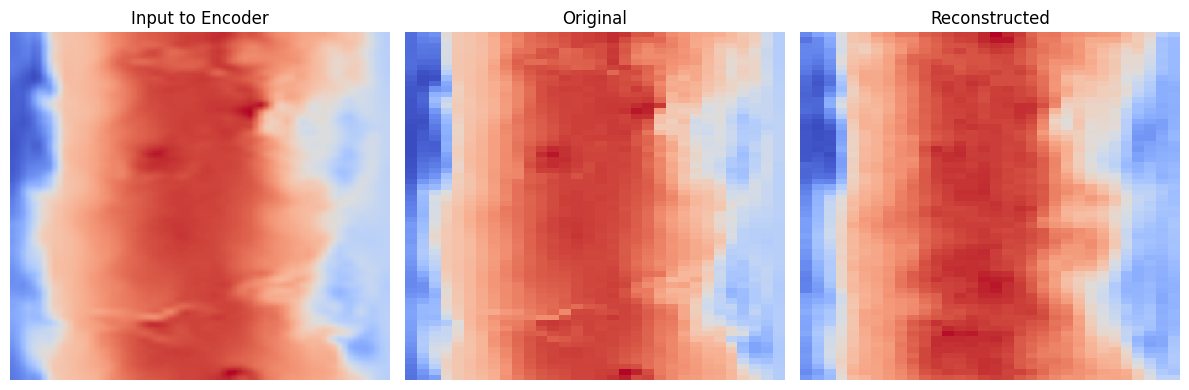

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(x_temp, cmap="coolwarm", aspect="auto")
axs[0].set_title("Input to Encoder")
axs[0].axis("off")

axs[1].imshow(x_orig_temp, cmap="coolwarm", aspect="auto")
axs[1].set_title("Original")
axs[1].axis("off")

axs[2].imshow(recon_x_temp, cmap="coolwarm", aspect="auto")
axs[2].set_title("Reconstructed")
axs[2].axis("off")

plt.tight_layout()
plt.show()

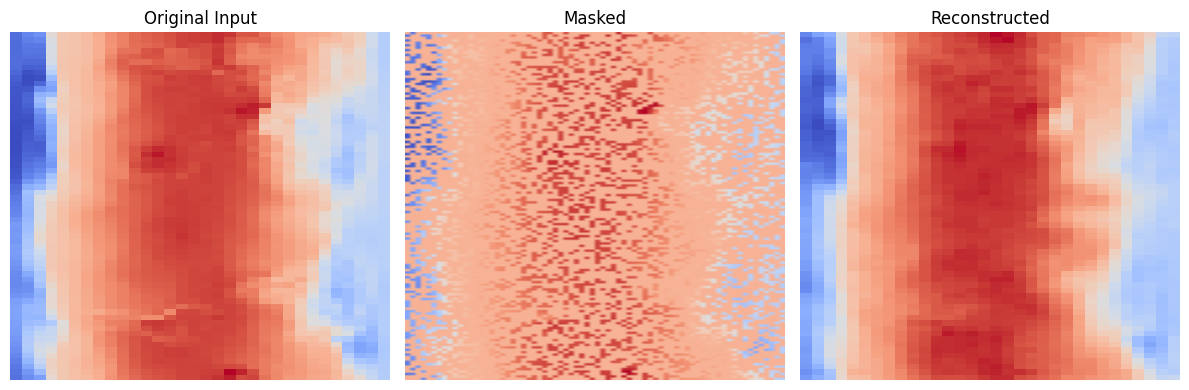

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(x_orig_temp, cmap="coolwarm", aspect="auto")
axs[0].set_title("Original Input")
axs[0].axis("off")

axs[1].imshow(masked_x_temp, cmap="coolwarm", aspect="auto")
axs[1].set_title("Masked")
axs[1].axis("off")

axs[2].imshow(recon_masked_x_temp, cmap="coolwarm", aspect="auto")
axs[2].set_title("Reconstructed")
axs[2].axis("off")

plt.tight_layout()
plt.show()